# Prepare data

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
with open("../data/train.csv") as f:
    training_lines_all = [line for line in f]

In [6]:
training_lines = [np.array(line.split(","), dtype='float32') for line in training_lines_all[1:]]

In [7]:
training_images = []
training_labels = []
training_set = []
for line in training_lines:
    one_hot = np.zeros((10), dtype='float32')
    one_hot[int(line[0])] = 1.0
    training_labels.append(one_hot)
    training_images.append(np.array(line[1:], dtype='float32'))
    training_set.append((one_hot, line[1:]))

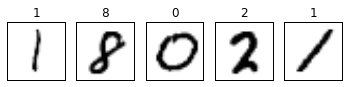

In [8]:
## See random 5 digit with their labels
random.shuffle(training_set)
fig = plt.figure()
for i, digit in enumerate(training_set[:5]):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(digit[0].nonzero()[0][0])  ## Label
    plt.imshow(digit[1].reshape((28, 28)), cmap=plt.cm.Greys)

# Preparing network

In [8]:
import tensorflow as tf
import time

In [19]:
## Hyper-parameters
HIDDEN_SIZE = 500
LR = 1e-3
BATCH_SIZE = 100
EPOCH = 10
## Constant
TRAINING_SIZE = len(training_set)
#TRAINING_SIZE = 1000
BATCH = TRAINING_SIZE / BATCH_SIZE

In [10]:
## Input vector
x = tf.placeholder(tf.float32, [None, 784])  ## Here 'None' means that a dimension can be of any length

In [11]:
## Creating 3-layers nn (1-input(784), 1-hidden(100), 1-output(10))
W1 = tf.Variable(tf.truncated_normal([784, HIDDEN_SIZE], stddev=0.1))
b1 = tf.Variable(tf.zeros([HIDDEN_SIZE]))
W2 = tf.Variable(tf.truncated_normal([HIDDEN_SIZE, 10], stddev=0.1))
b2 = tf.Variable(tf.zeros([10]))

In [12]:
y1 = tf.nn.relu(tf.matmul(x, W1) + b1)
y2 = tf.matmul(y1, W2) + b2

In [13]:
y_ = tf.placeholder(tf.float32, [None, 10])  ## Correct answers

** Cross-entropy function **

$ -\sum y_{2} \log(y) $

In [14]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y2, y_))

In [15]:
train_step = tf.train.GradientDescentOptimizer(LR).minimize(cross_entropy)

In [16]:
## Check if our prediction matches the truth (gives list of booleans)
correct_prediction = tf.equal(tf.argmax(y2, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
## Launch the model in a session
sess = tf.Session()
if tf.__version__ == '0.10.0':
    sess.run(tf.initialize_all_variables())   ## tensorflow 0.10
else:
    sess.run(tf.global_variables_initializer())   ## tensorflow 0.12
    
saver = tf.train.Saver()

In [26]:
## Training
#saver.restore(sess, "../model/MLP_tensorflow/MLP_tensorflow.ckpt")
#print("Model restored.")

t0 = time.time()
for i in xrange(EPOCH):
    
    random.shuffle(training_set)
    batches = [training_set[k:k + BATCH_SIZE] for k in range(0, TRAINING_SIZE, BATCH_SIZE)]
  
    batch_images = np.array([np.array([digit[1] for digit in batch], dtype='float32')
                             for batch in batches], dtype='float32')
    batch_labels = np.array([np.array([digit[0] for digit in batch], dtype='float32')
                             for batch in batches], dtype='float32')
    
    total_accuracy = 0.0
    for j in xrange(BATCH):
        sess.run(train_step, feed_dict={x: batch_images[j], y_: batch_labels[j]})
        batch_accuracy = sess.run(accuracy, feed_dict={x: batch_images[j], y_: batch_labels[j]})
        total_accuracy += batch_accuracy
        
    print "Epoch",  (i + 1), ": {0:f}".format(total_accuracy / BATCH)
print "Total time:", time.time() - t0

#save_path = saver.save(sess, "../model/MLP_tensorflow/MLP_tensorflow.ckpt")
#print("Model saved in file: %s" %save_path)
sess.close()

Epoch 1 : 0.967643
Epoch 2 : 0.989929
Epoch 3 : 0.994357
Epoch 4 : 0.997048
Epoch 5 : 0.998310
Epoch 6 : 0.998786
Epoch 7 : 0.999262
Epoch 8 : 0.999714
Epoch 9 : 0.999738
Epoch 10 : 0.999833
Total time: 46.6335229874
